In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('../Data Preprocessing/merged_locations.csv')

In [2]:
# Extract latitude and longitude from 'Lat_Long_Rounded'
df[['Latitude', 'Longitude']] = df['Lat_Long_Rounded'].str.extract(r'\(([^,]+),\s*([^)]+)\)').astype(float)

# Select Features for Clustering
filtered_data = df[df['accident_count'] > 1].copy()
features = filtered_data.drop(columns=['Lat_Long_Rounded', 'location', 'lga', 'state'])

# Scale the Features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Elbow Method and Silhouette Score for Optimal Number of Clusters
inertia = []
silhouette_scores = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)
    if k > 1:
        silhouette_scores.append(silhouette_score(features_scaled, kmeans.labels_))

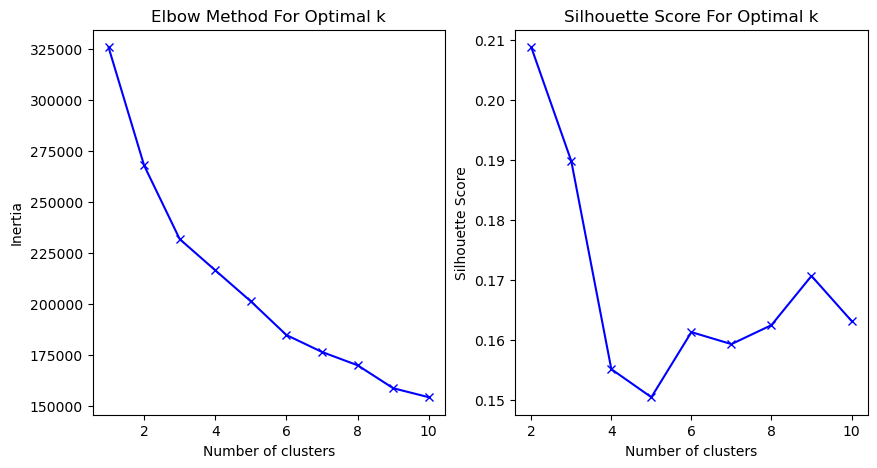

In [3]:
# Plot Elbow Method and Silhouette Score
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')

plt.subplot(1, 2, 2)
plt.plot(K[1:], silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.show()

In [4]:
# Apply KMeans Clustering with the chosen number of clusters
optimal_k = 3  # Adjust this based on the plots
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
filtered_data['cluster'] = kmeans.fit_predict(features_scaled)

# Assign rankings to clusters
cluster_means = filtered_data.groupby('cluster')['accident_count'].mean()
sorted_clusters = cluster_means.sort_values().index
cluster_ranking_map = {cluster: rank for rank, cluster in enumerate(sorted_clusters, 1)}

filtered_data['ranking'] = filtered_data['cluster'].map(cluster_ranking_map).map({1: 'Low', 2: 'Mid', 3: 'High'})

# Merge rankings back into the original dataframe
df = df.merge(filtered_data[['Lat_Long_Rounded', 'ranking']], on='Lat_Long_Rounded', how='left')
df['accident_prone_zone_rating'] = df['ranking']
df.loc[df['accident_count'] <= 1, 'accident_prone_zone_rating'] = 'Low'

# Save the final dataframe to a new CSV file
df.to_csv('Clustered_Data.csv', index=False)


In [5]:
# Define Visualization Parameters
cluster_colors = {'Low': 'blue', 'Mid': 'orange', 'High': 'red'}
cluster_sizes = {'Low': 5, 'Mid': 10, 'High': 15}

# Plot clusters on an interactive map
m = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=10)
for idx, row in df.iterrows():
    if pd.notna(row['accident_prone_zone_rating']):
        folium.CircleMarker(
            location=(row['Latitude'], row['Longitude']),
            radius=cluster_sizes[row['accident_prone_zone_rating']],
            color=cluster_colors[row['accident_prone_zone_rating']],
            fill=True,
            fill_color=cluster_colors[row['accident_prone_zone_rating']],
            fill_opacity=0.6,
            popup=f"Cluster: {row['accident_prone_zone_rating']}"
        ).add_to(m)

# Add Heatmap Layer
heat_data = [[row['Latitude'], row['Longitude'], row['accident_count']] for index, row in df.iterrows() if row['accident_count'] > 1]
HeatMap(heat_data).add_to(m)

# Save the map
m.save('accident_clusters_map.html')

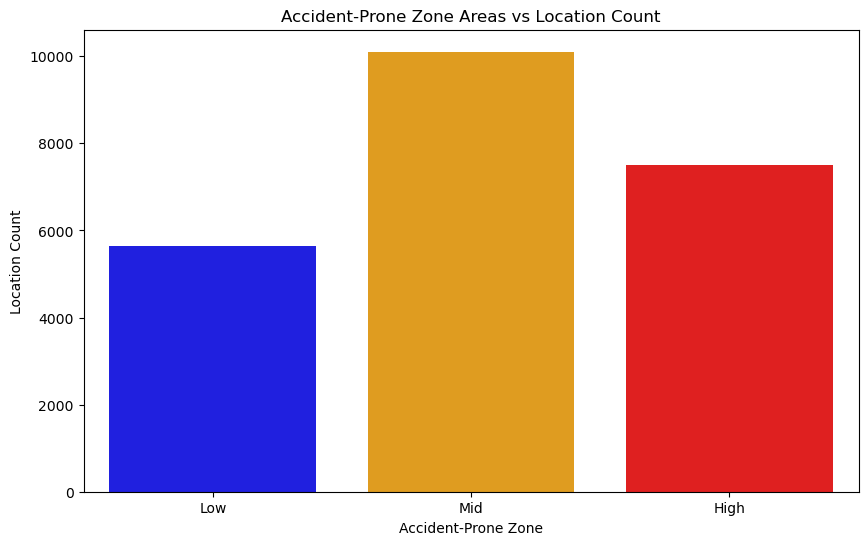

In [6]:
# Plot bar plot for zone counts
zone_counts = filtered_data['ranking'].value_counts().reindex(['Low', 'Mid', 'High'])
plt.figure(figsize=(10, 6))
sns.barplot(x=zone_counts.index, y=zone_counts.values, hue=zone_counts.index, palette=[cluster_colors['Low'], cluster_colors['Mid'], cluster_colors['High']], legend=False)
plt.title('Accident-Prone Zone Areas vs Location Count')
plt.xlabel('Accident-Prone Zone')
plt.ylabel('Location Count')
plt.show()

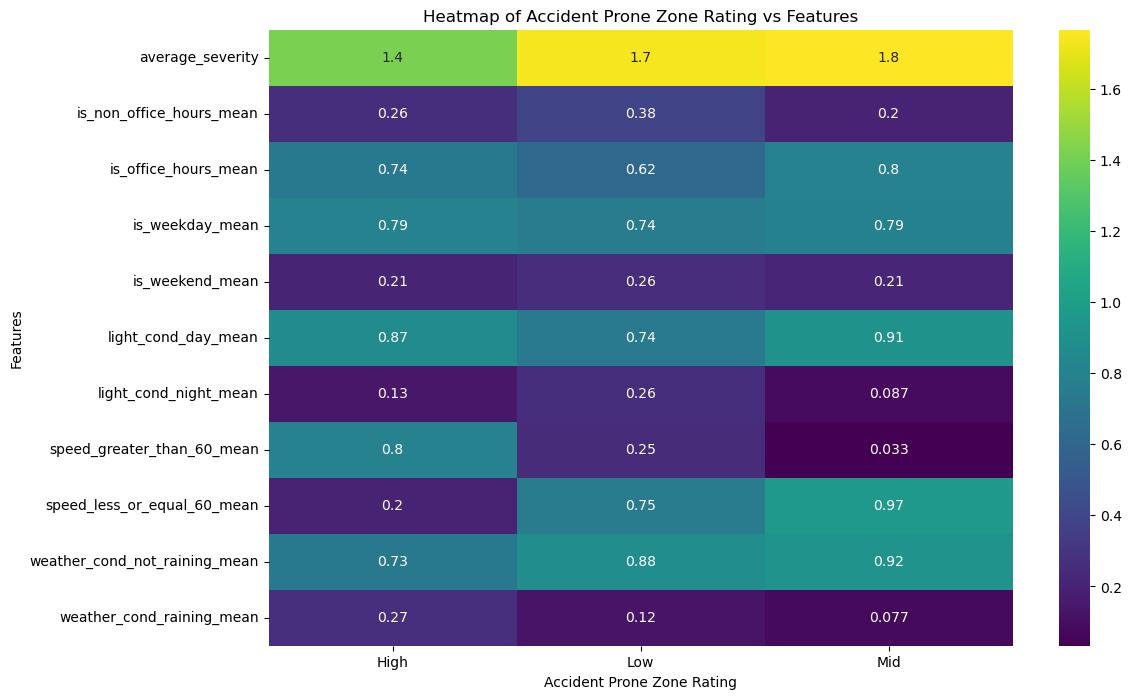

In [7]:
# Calculate Mean Values for Each Feature by Zone Rating
features_names = ['average_severity', 'is_weekday_mean', 'is_weekend_mean', 
                  'is_office_hours_mean', 'is_non_office_hours_mean', 'light_cond_day_mean', 
                  'light_cond_night_mean', 'weather_cond_not_raining_mean', 'weather_cond_raining_mean', 
                  'speed_less_or_equal_60_mean', 'speed_greater_than_60_mean']

heatmap_data = df.groupby('accident_prone_zone_rating')[features_names].mean().T.reset_index()
heatmap_data = heatmap_data.rename(columns={'index': 'Feature'})

# Melt the data for seaborn heatmap
heatmap_data_melted = heatmap_data.melt(id_vars=['Feature'], var_name='Accident Prone Zone Rating', value_name='Value')

# Plot Heatmap
plt.figure(figsize=(12, 8))
heatmap_pivot = heatmap_data_melted.pivot(index='Feature', columns='Accident Prone Zone Rating', values='Value')
sns.heatmap(heatmap_pivot, annot=True, cmap='viridis')
plt.title('Heatmap of Accident Prone Zone Rating vs Features')
plt.xlabel('Accident Prone Zone Rating')
plt.ylabel('Features')
plt.show()
